In [352]:
import material_interface as mi

ni_poscar = """Ni - primitive
1.0
   2.130422000	   0.000000000	   1.230000000
   0.710140800	   2.008582000	   1.230000000
   0.000000000	   0.000000000	   2.460000000
Ni
1
Selective dynamics
cartesian
   0.000000000    0.000000000    0.000000000 T T T Ni"""
au_poscar = """Au - primitive
1.0
   2.554775000	   0.000000000	   1.475000000
   0.851591600	   2.408665000	   1.475000000
   0.000000000	   0.000000000	   2.950000000
Au
1
Selective dynamics
cartesian
   0.000000000    0.000000000    0.000000000 T T T Au"""

graphene_poscar = """Graphene
1.0
   2.467291000	   0.000000000	   0.000000000
  -1.233645000	   2.136737000	   0.000000000
   0.000000000	   0.000000000	   7.803074000
C
2
direct
   0.000000000    0.000000000    0.000000000  C
   0.333333000    0.666667000    0.000000000  C
"""

from ase.build import surface, supercells
from ase.io import read, write
from ase.visualize import view
import io
import numpy as np

ni = mi.poscar_to_atoms(ni_poscar)
gr = mi.poscar_to_atoms(graphene_poscar)

print(ni.get_cell())
print(gr.get_cell())

ni_surface = surface(ni, (1, 1, 0), layers=3)
ni_surface.center(vacuum=10, axis=2)
ni_surface.wrap()
view(ni_surface * [3, 3, 1])

gr.center(vacuum=10, axis=2)
gr.wrap()
view(gr)
# ni_slab = supercells.make_supercell(ni_surface, [[3, 0, 0], [0, 3, 0], [0, 0, 1]])
# ni_slab.center(vacuum=10, axis=2)
# ni_slab.wrap()

# view(ni_slab)

print(mi.write_atoms_to_poscar(ni))

Cell([[2.130422, 0.0, 1.23], [0.7101408, 2.008582, 1.23], [0.0, 0.0, 2.46]])
Cell([[2.467291, 0.0, 0.0], [-1.233645, 2.136737, 0.0], [0.0, 0.0, 7.803074]])
Ni 
 1.0000000000000000
     2.1304219999999998    0.0000000000000000    1.2300000000000000
     0.7101408000000000    2.0085820000000001    1.2300000000000000
     0.0000000000000000    0.0000000000000000    2.4600000000000000
 Ni 
   1
Cartesian
  0.0000000000000000  0.0000000000000000  0.0000000000000000



In [353]:
# !pip install git+https://github.com/nmdl-mizo/interface_master.git@develop

In [354]:
"""interface_master"""
from interfacemaster.cellcalc import get_primitive_hkl, get_pri_vec_inplane, get_normal_index, get_normal_from_MI, rot
from interfacemaster.interface_generator import core, convert_vector_index
from interfacemaster.symmetric_tilt import get_csl_twisted_graphenes
from numpy import array, dot, round, cross, eye, pi, ceil, column_stack, arange
from numpy.linalg import inv, det, norm
from gb_code.csl_generator import print_list
import pandas as pd

from ase.io import write
import os


def write_atoms_to_cif(atoms, name):
    temp_filename = f"{name}.cif"
    write(temp_filename, atoms, format="cif")

    with open(temp_filename, "r") as file:
        content = file.read()

    return content


ni_cif = write_atoms_to_cif(ni, "m1")
gr_cif = write_atoms_to_cif(gr, "m2")

interface = core("m1.cif", "m2.cif")

hkl_1 = get_primitive_hkl([1, 1, 1], interface.conv_lattice_1, interface.lattice_1)
hkl_2 = get_primitive_hkl([0, 0, 1], interface.conv_lattice_2, interface.lattice_2)

interface.parse_limit(du=1e-2, S=1e-2, sgm1=50, sgm2=50, dd=1e-2)

interface.search_one_position_2D(hkl_1, hkl_2, theta_range=90, dtheta=0.01, exact=False)
interface.compute_bicrystal_two_D(hkl_1, hkl_2, normal_ortho=True, lim=50, tol_ortho=1e-2, tol_integer=1e-3)

Warning!, this programme will rewrite the POSCAR file in this dir!


/Users/mat3ra/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pymatgen/io/cif.py:1197: UserWarning: Issues encountered while parsing CIF: Some fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))


Congrates, we found an appx CSL!

U1 = 
[[ 0  0]
 [-4 -3]
 [ 7 -4]]; sigma_1 = 37

U2 = 
[[-3 -4]
 [ 4 -7]
 [ 0  0]]; sigma_2 = 37

D = 
[[ 0.9976693  -0.00699724  0.00420224]
 [ 0.00793899  0.99733634 -0.00349614]
 [-0.00189545  0.00512729  0.99900113]]

axis = [2.47055535 1.74694644 4.2791274 ] ; theta = 3.64

cell 1:
[[-3  0  0]
 [ 1 -4  3]
 [ 1  7  4]]
cell 2:
[[ 0 -3  4]
 [ 0  4  7]
 [-1  0  0]]


In [355]:
import material_interface as mi

settings = {
    "slab": {
        "miller:h": 1,
        "miller:k": 1,
        "miller:l": 0,
        "vacuum": 4,
        "number_of_layers": 3,
    },
    "interface": {"slab_v:matrix": [[-2, 11], [2, -11]], "layer_v:matrix": [[10, -5], [0, -20]], "distance": 2.0},
}
interface = mi.MaterialInterface(ni, gr, settings)
view(interface.structure)

LinAlgError: Singular matrix

In [ ]:
"""pymatgen"""
from pymatgen.analysis.interfaces.zsl import ZSLGenerator
from pymatgen.core.structure import Structure
from pymatgen.analysis.interfaces.coherent_interfaces import CoherentInterfaceBuilder

substrate = Structure.from_str(au_poscar, fmt="poscar")
layer = Structure.from_str(graphene_poscar, fmt="poscar")
substrate_miller = (2, 2, 1)
layer_miller = (0, 0, 1)

zsl = ZSLGenerator(max_area=100)
cib = CoherentInterfaceBuilder(
    substrate_structure=substrate,
    film_structure=layer,
    substrate_miller=substrate_miller,
    film_miller=layer_miller,
    zslgen=zsl,
)

cib._find_matches()
cib._find_terminations()
matches = cib.zsl_matches
terminations = cib.terminations
interfaces = list(cib.get_interfaces(terminations[0]))
print("Found {} matches".format(len(matches)))
print(f"TERMINATIONS: {len(terminations)}", terminations)
print(f"INTERFACES: {len(list(interfaces))}")

Found 2 matches
TERMINATIONS: 1 [('C_P6/mmm_2', 'Au_R-3m_1')]
INTERFACES: 2


In [ ]:
for interface in list(interfaces):
    print(interface.film)

match = matches[0]

film_sl_vectors = match.film_sl_vectors
film_vectors = match.film_vectors
substrate_sl_vectors = match.substrate_sl_vectors
substrate_vectors = match.substrate_vectors

from pymatgen.analysis.interfaces.substrate_analyzer import SubstrateMatch

substrate_match = SubstrateMatch.from_zsl(match, layer, layer_miller, substrate_miller)
print("von misses strain:\n", substrate_match.von_mises_strain)

Full Formula (C26)
Reduced Formula: C
abc   :   8.850000   8.850000  22.000000
angles:  90.000000  90.000000  60.000002
pbc   :       True       True       True
Sites (26)
  #  SP           a         b         c    bulk_equivalent  bulk_wyckoff    interface_label
---  ----  --------  --------  --------  -----------------  --------------  -----------------
  0  C     0.692308  0.076923  0.523377                  0  c               film
  1  C     0.769231  0.307692  0.523377                  0  c               film
  2  C     0.846154  0.538462  0.523377                  0  c               film
  3  C     0.923077  0.769231  0.523377                  0  c               film
  4  C     0.384615  0.153846  0.523377                  0  c               film
  5  C     0.461538  0.384615  0.523377                  0  c               film
  6  C     0.538462  0.615385  0.523377                  0  c               film
  7  C     0.615385  0.846154  0.523377                  0  c              

lenght: 2


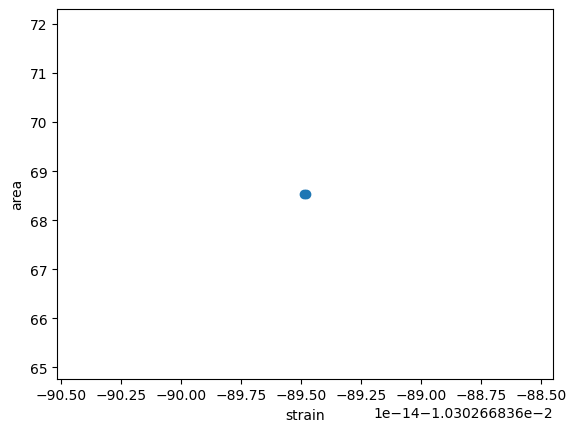

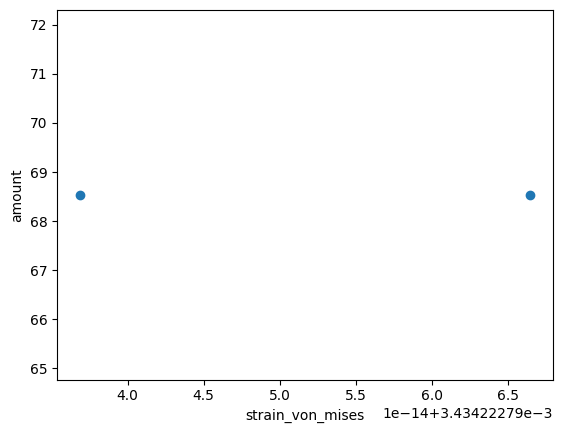

In [ ]:
interfaces = cib.get_interfaces(terminations[0], substrate_thickness=6)
interfaces_list = list(interfaces)

from ase.visualize import view

i = interfaces_list[0].to(fmt="poscar")
view(mi.poscar_to_atoms(i) * [3, 3, 1])

# map thru all the mathes and rank them by the strain
strain = []
strain_von_mises = []
amount = []
print("lenght:", len(matches))
for match in matches:
    substrate_match = SubstrateMatch.from_zsl(match, layer, layer_miller, substrate_miller)
    strain.append(substrate_match.strain.trace())
    strain_von_mises.append(substrate_match.von_mises_strain)
    amount.append(substrate_match.match_area)


# plot the strain and strain_von_misses vs number of atoms in the interface with scatter plot
import matplotlib.pyplot as plt

plt.plot(strain, amount, "o")
plt.xlabel("strain")
plt.ylabel("area")
plt.show()

plt.plot(strain_von_mises, amount, "o")
plt.xlabel("strain_von_mises")
plt.ylabel("amount")
plt.show()